# CH.3 분류

## 3.1 MNIST

In [14]:
import pandas as pd
import numpy as np

In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
X,y = mnist["data"], mnist["target"]
print(X.shape, y.shape)

(70000, 784) (70000,)


In [9]:
X.iloc[0]

pixel1      0
pixel2      0
pixel3      0
pixel4      0
pixel5      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Name: 0, Length: 784, dtype: int64

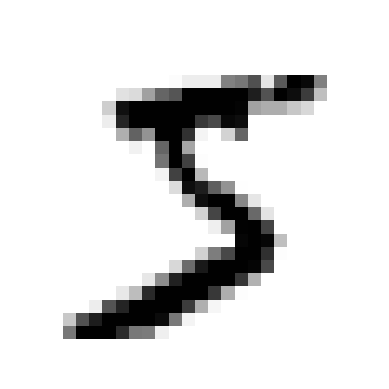

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.iloc[0].values
some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [12]:
y[0]

'5'

In [16]:
y = y.astype(np.uint8)

In [17]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000],y[60000:]

## 3.2 이진 분류기 훈련

In [21]:
# 이진 분류기
y_train_5 = (y_train ==5)
y_test_5 = (y_test==5)

In [19]:
from sklearn.linear_model import SGDClassifier

# 확률적 경사 하강법
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [20]:
sgd_clf.predict([some_digit])

/Users/yeseo/miniconda/envs/ame/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

## 3.3 성능 측정

### 3.3.1 교차 검증을 사용한 정확도 측정

In [22]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [25]:
from sklearn.base import BaseEstimator

# 숫자 5가 아니다 라고 예측하는 분류기
class Never5Classfier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self,X):
        return np.zeros((len(X),1), dtype=bool)

In [26]:
# 이미지의 10% 정도만 숫자 5이기 때문에 정확도가 약 90% 나옴
never_5_clf = Never5Classfier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

### 3.3.2 오차 행렬

In [27]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [29]:
from sklearn.metrics import confusion_matrix

# 오차 행렬
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

### 3.3.3 정밀도와 재현율

In [34]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.8370879772350012
0.6511713705958311


In [35]:
from sklearn.metrics import f1_score 

# F1 score: 정밀도와 재현율의 조화 평균
f1_score(y_train_5, y_train_pred)

0.7325171197343847

### 3.3.4 정밀도/재현율 트레이드오프

- 결정 함수  
- 결정 임곗값  

In [46]:
# decision_function을 통해 각 샘플의 점수를 얻을 수 있음
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[2164.22030239]
[ True]


/Users/yeseo/miniconda/envs/ame/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


In [47]:
# 임곗값을 높이면 재현율이 줄어듦
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [48]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [49]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

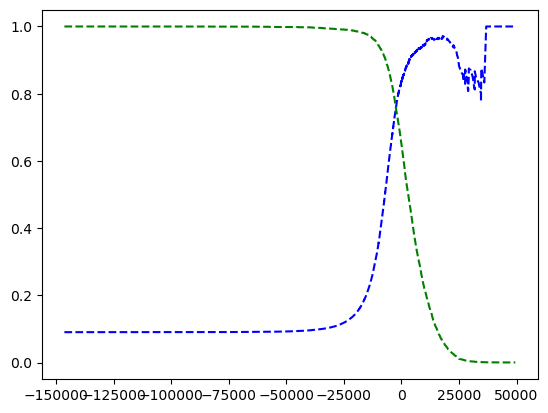

In [50]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label='정밀도')
    plt.plot(thresholds, recalls[:-1], "g--", label="재현율")

plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.show()

In [54]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]
y_train_pred_90 = y_scores >= threshold_90_precision
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


### 3.3.5 ROC 곡선

- 재현율(TPR)이 높을수록 거짓 양성(FPR)이 늘어난다.  
- 곡선 아래의 면적 (AUC)가 1이면 완벽한 분류기이고, 0.5이면 완전 랜덤한 분류기이다.  

In [66]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

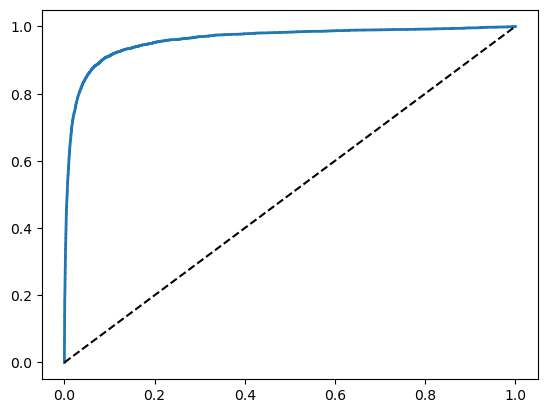

In [67]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')

plot_roc_curve(fpr, tpr)
plt.show()

In [69]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [68]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [59]:
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

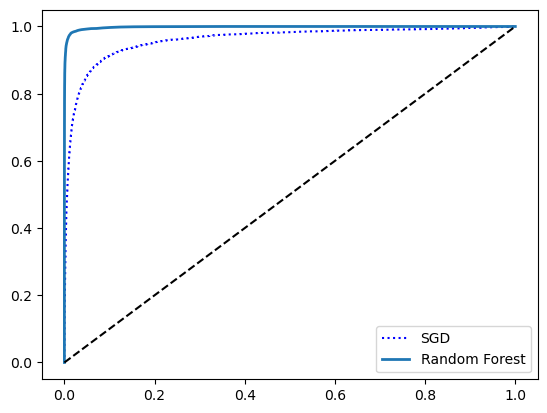

In [63]:
# 랜덤 포레스트 ROC 곡선이 SGD 보다 AUC 값이 더 크기 때문에 랜덤 포레스트 분류기가 더 좋다.  
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [70]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983296721818179

## 3.4 다중 분류

In [71]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

/Users/yeseo/miniconda/envs/ame/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

In [72]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

/Users/yeseo/miniconda/envs/ame/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [74]:
print(np.argmax(some_digit_scores))
print(svm_clf.classes_)

5
[0 1 2 3 4 5 6 7 8 9]


In [75]:
from sklearn.multiclass import OneVsOneClassifier

# OvO, N(N-1)/2 개의 분류기가 필요(N: 클래스 개수)
ovr_clf = OneVsOneClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])
len(ovr_clf.estimators_)

/Users/yeseo/miniconda/envs/ame/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but OneVsOneClassifier was fitted with feature names
  warnings.warn(


45

In [76]:
# SGDClassifier
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

/Users/yeseo/miniconda/envs/ame/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([3], dtype=uint8)

In [77]:
sgd_clf.decision_function([some_digit])

/Users/yeseo/miniconda/envs/ame/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [78]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [80]:
from sklearn.preprocessing import StandardScaler

# 간단하게 표준화로 입력 스케일을 조정하여 정확도를 높일 수 있음
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

## 3.5 에러 분석

In [81]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train,y_train_pred)

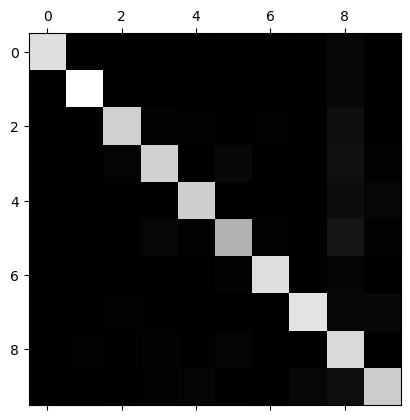

In [82]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

In [83]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

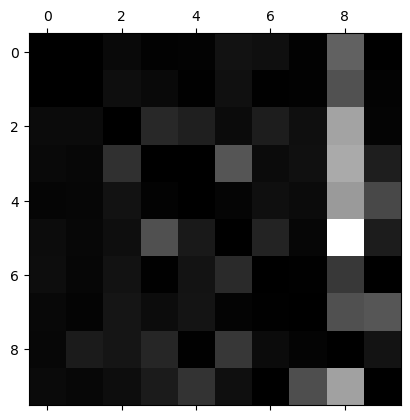

In [84]:
# 주대각선만 0으로 채움
# 행: 실재 클래스, 열: 예측한 클래스
np.fill_diagonal(norm_conf_mx,0)
plt. matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

In [111]:
# 숫자 그림을 위한 추가 함수
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # n_rows = ceil(len(instances) / images_per_row) 와 동일합니다:
    n_rows = (len(instances) - 1) // images_per_row + 1

    # 필요하면 그리드 끝을 채우기 위해 빈 이미지를 추가합니다:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate(
        [instances, np.zeros((n_empty, size * size))], axis=0
    )

    # 배열의 크기를 바꾸어 28×28 이미지를 담은 그리드로 구성합니다:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # 축 0(이미지 그리드의 수직축)과 2(이미지의 수직축)를 합치고 축 1과 3(두 수평축)을 합칩니다.
    # 먼저 transpose()를 사용해 결합하려는 축을 옆으로 이동한 다음 합칩니다:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(
        n_rows * size, images_per_row * size
    )
    # 하나의 큰 이미지를 얻었으므로 출력하면 됩니다:
    plt.imshow(big_image, cmap=mpl.cm.binary, **options)
    plt.axis("off")

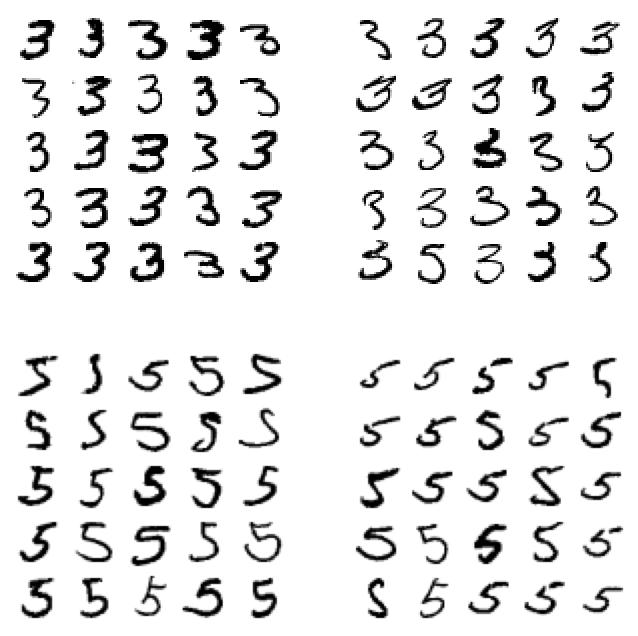

In [112]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8, 8))
plt.subplot(221)
plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222)
plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223)
plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224)
plot_digits(X_bb[:25], images_per_row=5)
plt.show()

- 선형 모델인 SGDClassifier를 사용 -> 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 가중치 합을 클래스의 점수로 계산함  
- 3과 5는 몇 개의 픽셀만 다르기 때문에 모델이 쉽게 혼동  
- 분류기가 이미지의 위치나 회전 방향에 매우 민감  
- 3과 5의 에러를 줄이는 한 가지 방법은 이미지를 중앙에 위치시키고 회전되어 있지 않도록 전처리 하는 것   

## 3.6 다중 레이블 분류

In [114]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >=7)
y_train_odd = (y_train % 2 == 1)
# 7보다 큰 값인지, 홀수인지 총 두 개의 타깃 레이블로 구성
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

In [115]:
knn_clf.predict([some_digit])

/Users/yeseo/miniconda/envs/ame/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

In [116]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

# 모든 레이블의 가중치가 같다고 가정하고 F1 점수의 평균 계산
# average='weighted'로 가중치 설정
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.9764102655606048

## 3.7 다중 출력 분류

In [135]:
# 입력 데이터 X: 숫자 이미지에 노이즈 추가
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
# 타겟 데이터 y: 노이즈가 제거된 기존 입력 데이터(숫자 이미지)
y_train_mod = X_train
y_test_mod = X_test

In [126]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap=mpl.cm.binary, interpolation="nearest")
    plt.axis("off")

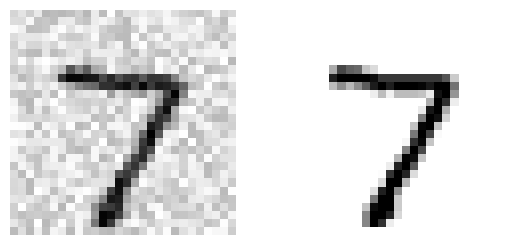

In [136]:
# TODO: 잡음이 많은 숫자 이미지를 입력으로 받아 깨끗한 숫자 이미지를 출력
some_index = 0
plt.subplot(121)
plot_digit(X_test_mod.iloc[some_index].values)
plt.subplot(122)
plot_digit(y_test_mod.iloc[some_index].values)
plt.show()

/Users/yeseo/miniconda/envs/ame/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


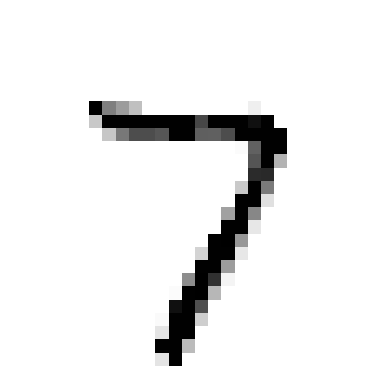

In [134]:

knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod.iloc[some_index].values])
plot_digit(clean_digit)

## 3.8 연습문제

### 1. MNIST 데이터셋으로 분류기를 만들어 테스트 세트에서 97% 정확도 달성하기  
- 힌트: KNeighborsClassifier + 하이퍼파라미터 그리드 탐색 (weights와 n_neighbors)  

### 2. MNIST 이미지를 (왼, 오른, 위, 아래) 어느 방향으로든 한 픽셀 이동시킬 수 있는 함수 만들어 훈련 세트 확장(데이터 증식)
- 훈련 세트에 있는 각 이미지에 대해 네 개의 복사본을 만들어 훈련 세트에 추가  
-  확장된 데이터셋으로 훈련시키고 테스트 세트에서 정확도를 측정하여 성능이 더 높아졌는지 확인  

### 3. 타이타닉 데이터셋에 도전 in Kaggle

### 4. 스팸 분류기 만들기
- 아파치 스팸어새신 공공 데이터셋 (https://homl.info/spamassassin) 샘플 내려받기  
- 데이터 불러오기 & 형식 살펴보기  
- 훈련/테스트 세트 분할하기  
- 각 이메일을 특성 벡터로 변환하는 데이터 준비 파이프라인 제작 (하나의 이메일을 가능한 단어의 존재 여부를 나타내는 희소 벡토로 바꿔야 함, 예를 들어 'Hello you Hello Hello you'는 [1,0,0,1](hello 있음, how 없음, you 있음)로 변환되거나 [3,0,0,2](단어 출현 횟수)로 변환되어야 함)  
- 준비 파이프라인에 이메일 헤더 제거, 소문자 변환, 구두점 제거, 모든 URLs 주소를 'URL'로 대체, 모든 숫자를 'NUMBER'로 대체, 어간 추출(라이브러리 활용) 등을 수행할지 여부를 제어하기 위한 파라미터 추가  
- 여러 분류기를 시도하여 재현율과 정밀도가 모두 높은 스팸 분류기 제작  